# CME193 project - Seismic inversion using machine learning 

## Submitted by Vishal Das

In this project, I used 1D convolutional neural networks to predict acoustic impedance from given input seismic waveform. This is a crucial step in seismology where seismic waves are used for probing the earth. Impedance forms an important step in the interpretation of the earth's properties. Conventionally, impedance is inverted from the seismic data using some approximations. In my workflow, I use machine learning to allow machines to learn the inversion workflow by training it using synthetic dataset. The synthetic dataset has been generated using Geostatistical techniques and Markov Chain Monte Carlo process along with full waveform seismic forward modeling. The current data is considering 1D wave propagation, that can be considered similar to well logs. 

The current architecture of the neural network consists of two 1D convolutional neural network layers with a Rectified Linear Unit at the end of each 1D CNN. The loss function for the training case is defined as the mean square error loss. I have used PyTorch for setting up the neural network and for training the network. 520 samples are used as training data. The training is performed for 1000 iterations. The network architecture and the hyperparameters were chosen based on trial and error method. This is still a work in progress. I am only presenting a preliminary implementation. 

The execution of the code assumes that CUDA version of pytorch is already installed. After training the network, it has been used to predict impedance using test dataset that was not used for the training process. The test results seemed promising. As part of the future work, the network will be made deeper to capture for more subtle changes in the impedance output for the test results. The results of the neural network depends heavily on the hyperpaprameters. A slight change in some of the hyperparameters impacted the results heavily. I plan to do an exhaustive hyperparameter search to deduce the perfect set of hyperparameters suitable for the model. As an extension, the network will be test on a real well data to evaluate the performance for real business cases. The final goal of the project is to extend the 1D version to 2D/ 3D data and even 4D seismic that is becoming popular in the current time especially for reservoir surveillance purposes. 


In [1]:
# All pre-requisites for running the codes. Assumes that CUDA version of pytorch is installed
import seaborn as sns
import torch 
import torch.nn as nn
import torch.autograd 
from torch.autograd import Variable
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
import torch.nn.functional as F
from scipy.interpolate import UnivariateSpline
import pandas as pd
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.manifold import MDS
from sklearn.datasets import make_classification
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [3]:
# Function to convert reflectivity series to impedance values
def rcs2imp(rcs,znot):
    ircs = np.zeros(rcs.size)
    n = rcs.size
    # rcs2 = (rcs[1:n]+rcs[0:n-1])/2.
    ircs=np.cumsum(rcs)
    imp=znot*np.exp(2*ircs)  
    
    return imp



In [14]:
# Loading the Training data 
# and separating into training and test set
dataframe = sio.loadmat('Train_DataSyn_Ricker30.mat')

#make sure not to take too many traces
howMany = 2000 # Seismic data considered out of 2100 data points 
np.random.seed(9) # For replication of results
indxRand = [randint(0,dataframe['wz_with_multiples'].shape[1]-1) for p in range(0,howMany)]

# Seismic traces
TrainingSeismic = dataframe['wz_with_multiples']
TrainingSeismic = TrainingSeismic.transpose()
TrainingSeismic = TrainingSeismic[indxRand,:]

# Impedance
TrainingImpedance = dataframe['IpTimeVec']/1e6
TrainingImpedance = TrainingImpedance.transpose()
TrainingImpedance = TrainingImpedance[indxRand,:]

# Testing--> Not Trained on Data
dataframe = sio.loadmat('HardTest_DataSyn_Ricker30.mat')

TestingSeismic = dataframe['wz_with_multiples']
TestingSeismic = TestingSeismic.transpose()[:, 0:333]

TestingImpedance = dataframe['IpTimeVec']/1e6
TestingImpedance = TestingImpedance.transpose()[:, 0:333]

print(TestingImpedance.shape[1])


dt = 4.3875e-4
time = np.linspace(0,(TrainingSeismic.shape[1]-1)*dt,TrainingSeismic.shape[1]) 

331


In [3]:
sampleNumber = 10

datasetSeismicTrace = TestingSeismic[sampleNumber,:]
print(datasetSeismicTrace.shape)
datasetIpTrace = TestingImpedance[sampleNumber,:]
print(datasetIpTrace.shape)
print(time.shape) 

(331,)
(331,)
(331,)


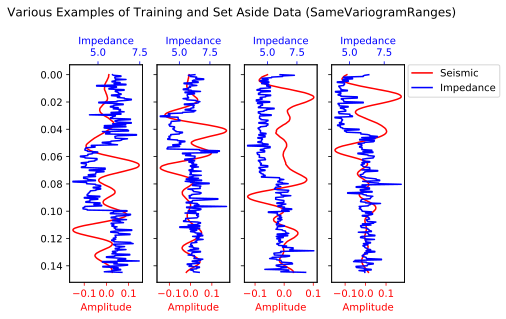

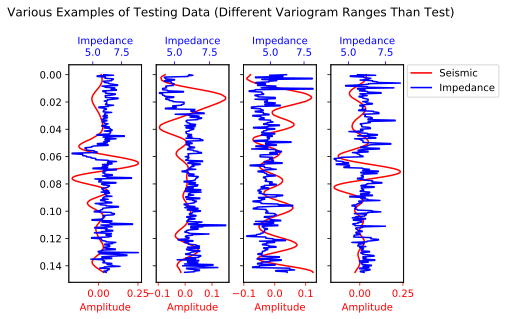

In [4]:
# Make one graph showing sample Training Data
sampleNumbers = np.array([2,54,123,209])

fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].invert_yaxis()
fig.suptitle('Various Examples of Training and Set Aside Data (SameVariogramRanges)', y=1.08)

# Seismic traces
for i in range(4):
    sampleNumber = sampleNumbers[i];
    datasetSeismicTrace = TrainingSeismic[sampleNumber,:]
    datasetIpTrace = TrainingImpedance[sampleNumber,:]
    
    line1, = axs[i].plot(datasetSeismicTrace, time, 'r-')
    axs[i].set_xlabel('Amplitude', color='r')
    axs[i].tick_params('x', colors='r')
    ax2 = axs[i].twiny()
    line2, = ax2.plot(datasetIpTrace, time, 'b-')
    ax2.set_xlabel('Impedance', color='b')
    ax2.tick_params('x', colors='b')
lgd = plt.legend((line1, line2), ('Seismic', 'Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.savefig('Figures/ExamplesOfTrainingSets.png', bbox_extra_artists=(lgd,), bbox_inches='tight') 

# Make one graph showing sample Training Data
sampleNumbers = np.array([2,54,123,209])

fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].invert_yaxis()
fig.suptitle('Various Examples of Testing Data (Different Variogram Ranges Than Test)', y=1.08)

# Seismic traces
for i in range(4):
    sampleNumber = sampleNumbers[i];
    datasetSeismicTrace = TestingSeismic[sampleNumber,:]
    datasetIpTrace = TestingImpedance[sampleNumber,:]
    
    line1, = axs[i].plot(datasetSeismicTrace, time, 'r-')
    axs[i].set_xlabel('Amplitude', color='r')
    axs[i].tick_params('x', colors='r')
    ax2 = axs[i].twiny()
    line2, = ax2.plot(datasetIpTrace, time, 'b-')
    ax2.set_xlabel('Impedance', color='b')
    ax2.tick_params('x', colors='b')
lgd = plt.legend((line1, line2), ('Seismic', 'Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.savefig('Figures/ExamplesOfTestingSets.png', bbox_extra_artists=(lgd,), bbox_inches='tight') 

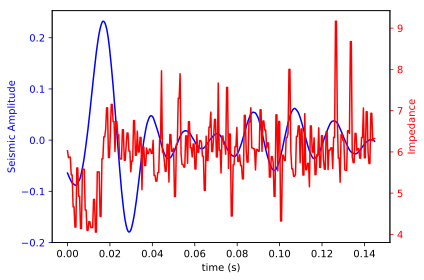

In [15]:
# Separating the selected traces into training and test sets
# Preprocessing of data before using in the network

#total 2000 
#validation 300
#testing 300
#training 1400

howManyToValidate = 300
howManyToTest = 300 
fromWhich = 0 # Based on maximum of the source wavelet
tillWhich = TrainingSeismic.shape[1] # Based on last sample before interpolation of impedance and reflection coefficients

valX = (TrainingSeismic[:howManyToValidate,fromWhich:tillWhich]) 
testX = (TrainingSeismic[howManyToValidate:howManyToValidate+howManyToTest,fromWhich:tillWhich])
trainX = (TrainingSeismic[howManyToValidate+howManyToTest:,fromWhich:tillWhich])

valX = torch.FloatTensor(np.reshape(valX, (valX.shape[0], 1, valX.shape[1])))
testX = torch.FloatTensor(np.reshape(testX, (testX.shape[0], 1, testX.shape[1])))
trainX = torch.FloatTensor(np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])))

valIp = (TrainingImpedance[:howManyToValidate,0:-fromWhich+tillWhich])
testIp = (TrainingImpedance[howManyToValidate:howManyToValidate+howManyToTest,0:-fromWhich+tillWhich])
trainIp = (TrainingImpedance[howManyToValidate+howManyToTest:,0:-fromWhich+tillWhich])

valIp = torch.FloatTensor(np.reshape(valIp, (valIp.shape[0], 1, valIp.shape[1])))
testIp = torch.FloatTensor(np.reshape(testIp, (testIp.shape[0], 1, testIp.shape[1])))
trainIp = torch.FloatTensor(np.reshape(trainIp, (trainIp.shape[0], 1, trainIp.shape[1])))


signalLength = trainX.shape[0]

# Plotting the data after preprocessing. This is used as input for the training as well as test
fig = plt.figure()
sampleNumber = 10;

np.linspace(2.0, 3.0, num=5)
fig, ax1 = plt.subplots()
ax1.plot(time, trainX[sampleNumber,0,:].numpy(), 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Seismic Amplitude', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(time, trainIp[sampleNumber,0,:].numpy(), 'r-')
ax2.set_ylabel('Impedance', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()
# fig.savefig('Figures/InputVsOutput.png') 

In [16]:
# Hyperparameters for the CNN
num_epochs = 500
batch_size = 1
learning_rate = 0.001

noOfNeurons = 60
dilation = 1
kernel_size = 300
stride = 1
padding = int(((dilation*(kernel_size-1)-1)/stride-1)/2)
print("Padding size {}".format(padding))

class rcs2impcnn(nn.Module):
    def __init__(self):
        super(rcs2impcnn, self).__init__()

    def forward(self, x, ipp):
        return ipp*torch.exp(2*torch.cumsum(x,2)).cuda()

# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            # input, output, kernel, stride  ...  kernel_size<stride+traces.shape[2]
#            Lin+2∗padding−dilation∗(kernel_size−1)−1)/stride+1
            nn.Conv1d(1, noOfNeurons, kernel_size=kernel_size, stride=1, padding = padding+1),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv1d(noOfNeurons, 1, kernel_size=kernel_size, stride=1, padding = padding+2),
            nn.ReLU())
#         self.layer1 = nn.Sequential(
#             # input, output, kernel, stride  ...  kernel_size<stride+traces.shape[2]
# #            Lin+2∗padding−dilation∗(kernel_size−1)−1)/stride+1
#             nn.Conv1d(1, noOfNeurons, kernel_size=kernel_size, stride=1, padding = padding+1),
#             nn.ReLU(),
#             nn.Conv1d(noOfNeurons, 1, kernel_size=kernel_size, stride=1, padding = padding+2),
#             nn.Tanh())
#         self.rcs2imp = rcs2impcnn()

    

    def forward(self, x):
        out = self.layer1(x)
        # out = F.tanh(self.layer2(out))
        out = self.layer2(out)
        # out = out.view(out.size(0), -1)

#         ipp = ipp.repeat(1,1,out.size()[2])
#         ipp = ipp.permute(1, 0, 2)
#         out = self.rcs2imp(out,ipp)

        
#        out = self.fc(out)

        return out

cnn = CNN()
cnn.cuda() 

Padding size 148


CNN(
  (layer1): Sequential(
    (0): Conv1d (1, 60, kernel_size=(300,), stride=(1,), padding=(149,))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv1d (60, 1, kernel_size=(300,), stride=(1,), padding=(150,))
    (1): ReLU()
  )
)

In [12]:
# Training the model

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

batch_size_tot = trainX.shape[0]
no_of_batches = (batch_size_tot - batch_size_tot%batch_size)/batch_size
no_of_batches = int(no_of_batches)

trainLosses = []   
valLosses = [] 

# Train the Model
for epoch in range(num_epochs):
        for ii in range(no_of_batches):
#            optimizer.zero_grad()
#            traces = Variable(trainX[ii*batch_size:(ii+1)*batch_size,:,:]).cuda()  
            # First value of Ip used if the loss criteria is impedance instead of reflection coefficients
            ipp = Variable(trainIp[ii*batch_size:(ii+1)*batch_size,:,0]).cuda()  
#            outputs = cnn(traces,ipp)
#            
#            outputs = outputs.view(batch_size, 1, outputs.size()[1])
#            yy = Variable(trainIp[ii*batch_size:(ii+1)*batch_size,:,:]).cuda();

            
            traces = Variable(trainX[ii*batch_size:(ii+1)*batch_size,:,:]).cuda()
        

            outputs = cnn(traces)
            
#            refl_train = Variable(trainY[ii*batch_size:(ii+1)*batch_size,:,:]).cuda()
            ipyy = Variable(trainIp[ii*batch_size:(ii+1)*batch_size,:,:]).cuda()
            
#             plt.plot(traces.data.cpu().numpy()[0,0,:], '-k')
#             plt.pause(0.05)

            loss = criterion(outputs, ipyy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        trainLosses.append(loss.data[0])
        
#       Validation error      
        traces_val = Variable(valX).cuda()
        outputs_val = cnn(traces_val)
        ipyy_val = Variable(valIp).cuda()
        loss_val = criterion(outputs_val, ipyy_val)
        valLosses.append(loss_val.data[0]) 
            
        print ('Epoch [%d/%d], Iter [%d], Train Loss: %.6f, Validation Loss: %.6f' 
                   %(epoch+1, num_epochs, ii+1, loss.data[0], loss_val.data[0]))
        
del traces
del outputs



Epoch [1/500], Iter [1400], Train Loss: 0.427760, Validation Loss: 0.506369
Epoch [2/500], Iter [1400], Train Loss: 0.381505, Validation Loss: 0.460182
Epoch [3/500], Iter [1400], Train Loss: 0.323962, Validation Loss: 0.439267
Epoch [4/500], Iter [1400], Train Loss: 0.302861, Validation Loss: 0.416049
Epoch [5/500], Iter [1400], Train Loss: 0.299482, Validation Loss: 0.406736
Epoch [6/500], Iter [1400], Train Loss: 0.289721, Validation Loss: 0.389555
Epoch [7/500], Iter [1400], Train Loss: 0.285447, Validation Loss: 0.376248
Epoch [8/500], Iter [1400], Train Loss: 0.279247, Validation Loss: 0.368254
Epoch [9/500], Iter [1400], Train Loss: 0.273551, Validation Loss: 0.361012
Epoch [10/500], Iter [1400], Train Loss: 0.280716, Validation Loss: 0.359754
Epoch [11/500], Iter [1400], Train Loss: 0.272153, Validation Loss: 0.357078
Epoch [12/500], Iter [1400], Train Loss: 0.270498, Validation Loss: 0.354826
Epoch [13/500], Iter [1400], Train Loss: 0.261400, Validation Loss: 0.349921
Epoch [1

Epoch [108/500], Iter [1400], Train Loss: 0.237748, Validation Loss: 0.239063
Epoch [109/500], Iter [1400], Train Loss: 0.222660, Validation Loss: 0.235899
Epoch [110/500], Iter [1400], Train Loss: 0.209238, Validation Loss: 0.233194
Epoch [111/500], Iter [1400], Train Loss: 0.227251, Validation Loss: 0.237771
Epoch [112/500], Iter [1400], Train Loss: 0.206408, Validation Loss: 0.235344
Epoch [113/500], Iter [1400], Train Loss: 0.218165, Validation Loss: 0.233644
Epoch [114/500], Iter [1400], Train Loss: 0.197512, Validation Loss: 0.233208
Epoch [115/500], Iter [1400], Train Loss: 0.181812, Validation Loss: 0.228737
Epoch [116/500], Iter [1400], Train Loss: 0.209804, Validation Loss: 0.227253
Epoch [117/500], Iter [1400], Train Loss: 0.205353, Validation Loss: 0.225253
Epoch [118/500], Iter [1400], Train Loss: 0.205586, Validation Loss: 0.227975
Epoch [119/500], Iter [1400], Train Loss: 0.190830, Validation Loss: 0.222258
Epoch [120/500], Iter [1400], Train Loss: 0.185394, Validation L

Epoch [214/500], Iter [1400], Train Loss: 0.152488, Validation Loss: 0.185088
Epoch [215/500], Iter [1400], Train Loss: 0.148245, Validation Loss: 0.184888
Epoch [216/500], Iter [1400], Train Loss: 0.147061, Validation Loss: 0.187993
Epoch [217/500], Iter [1400], Train Loss: 0.157594, Validation Loss: 0.186157
Epoch [218/500], Iter [1400], Train Loss: 0.156102, Validation Loss: 0.187763
Epoch [219/500], Iter [1400], Train Loss: 0.155169, Validation Loss: 0.183151
Epoch [220/500], Iter [1400], Train Loss: 0.153104, Validation Loss: 0.186131
Epoch [221/500], Iter [1400], Train Loss: 0.150635, Validation Loss: 0.185096
Epoch [222/500], Iter [1400], Train Loss: 0.149413, Validation Loss: 0.185981
Epoch [223/500], Iter [1400], Train Loss: 0.145905, Validation Loss: 0.188489
Epoch [224/500], Iter [1400], Train Loss: 0.145744, Validation Loss: 0.183599
Epoch [225/500], Iter [1400], Train Loss: 0.145611, Validation Loss: 0.187347
Epoch [226/500], Iter [1400], Train Loss: 0.148409, Validation L

Epoch [320/500], Iter [1400], Train Loss: 0.136597, Validation Loss: 0.176044
Epoch [321/500], Iter [1400], Train Loss: 0.136251, Validation Loss: 0.176071
Epoch [322/500], Iter [1400], Train Loss: 0.131513, Validation Loss: 0.175276
Epoch [323/500], Iter [1400], Train Loss: 0.140832, Validation Loss: 0.175204
Epoch [324/500], Iter [1400], Train Loss: 0.132042, Validation Loss: 0.173354
Epoch [325/500], Iter [1400], Train Loss: 0.131990, Validation Loss: 0.175239
Epoch [326/500], Iter [1400], Train Loss: 0.136689, Validation Loss: 0.173950
Epoch [327/500], Iter [1400], Train Loss: 0.131952, Validation Loss: 0.174099
Epoch [328/500], Iter [1400], Train Loss: 0.134698, Validation Loss: 0.174949
Epoch [329/500], Iter [1400], Train Loss: 0.135163, Validation Loss: 0.173526
Epoch [330/500], Iter [1400], Train Loss: 0.137818, Validation Loss: 0.175025
Epoch [331/500], Iter [1400], Train Loss: 0.133530, Validation Loss: 0.172611
Epoch [332/500], Iter [1400], Train Loss: 0.133907, Validation L

Epoch [426/500], Iter [1400], Train Loss: 0.129701, Validation Loss: 0.169197
Epoch [427/500], Iter [1400], Train Loss: 0.135798, Validation Loss: 0.169267
Epoch [428/500], Iter [1400], Train Loss: 0.137060, Validation Loss: 0.169624
Epoch [429/500], Iter [1400], Train Loss: 0.126229, Validation Loss: 0.166190
Epoch [430/500], Iter [1400], Train Loss: 0.142464, Validation Loss: 0.168784
Epoch [431/500], Iter [1400], Train Loss: 0.129214, Validation Loss: 0.168358
Epoch [432/500], Iter [1400], Train Loss: 0.136407, Validation Loss: 0.168432
Epoch [433/500], Iter [1400], Train Loss: 0.145169, Validation Loss: 0.169015
Epoch [434/500], Iter [1400], Train Loss: 0.134410, Validation Loss: 0.169249
Epoch [435/500], Iter [1400], Train Loss: 0.139100, Validation Loss: 0.166883
Epoch [436/500], Iter [1400], Train Loss: 0.139245, Validation Loss: 0.167590
Epoch [437/500], Iter [1400], Train Loss: 0.129629, Validation Loss: 0.167520
Epoch [438/500], Iter [1400], Train Loss: 0.135297, Validation L

In [9]:
# Save the Trained Model
with open('cnn_KernSize' + str(kernel_size) + '_NoOfNeurons' + str(noOfNeurons) + '_ForPaper.pkl', 'wb') as pickle_file:
     torch.save(cnn.state_dict(), pickle_file)
np.savez('lossdata.npz', name1=trainLosses, name2=valLosses)

In [17]:
# Loading the model
with open('cnn_KernSize' + str(kernel_size) + '_NoOfNeurons' + str(noOfNeurons) + '_ForPaper.pkl', 'rb') as pickle_file:
     cnn.load_state_dict(torch.load(pickle_file))
#np.load('lossdata.npz')

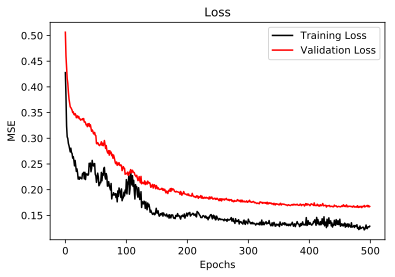

In [17]:
# Plotting the training + validation losses
fig, ax = plt.subplots()
ax.plot(trainLosses,'-k', label='Training Loss')
ax.plot(valLosses,'-r', label='Validation Loss')
legend = ax.legend(loc='upper right')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
fig.savefig('Figures/TrainingMSELoss.pdf', bbox_inches='tight', format='pdf', dpi=1200)


331


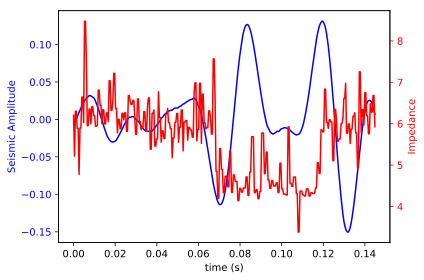

In [18]:
# Loading data for Posterior using ABC

dataframe_ABC = sio.loadmat('./ABC_dataset/Train_DataSyn_Ricker30.mat')
dataframe_facies_posterior = sio.loadmat('./ABC_dataset/Facies_posterior.mat')

#make sure not to take too many traces
howMany_ABC = 2100 # Seismic data considered out of 2100 data points 
np.random.seed(9) # For replication of results
indxRand_ABC = [randint(0,dataframe_ABC['wz_with_multiples'].shape[1]-1) for p in range(0,howMany_ABC)]

# Seismic traces
TrainingSeismic_ABC = dataframe_ABC['wz_with_multiples']
TrainingSeismic_ABC = TrainingSeismic_ABC.transpose()
TrainingSeismic_ABC = TrainingSeismic_ABC[indxRand_ABC,:]

# Impedance
TrainingImpedance_ABC = dataframe_ABC['IpTimeVec']/1e6
TrainingImpedance_ABC = TrainingImpedance_ABC.transpose()
TrainingImpedance_ABC = TrainingImpedance_ABC[indxRand_ABC,:]

# Facies 
Facies_ABC = dataframe_facies_posterior['Facies']
Facies_ABC = Facies_ABC.transpose()
Facies_ABC = Facies_ABC[indxRand_ABC,:]

print(TrainingImpedance_ABC.shape[1])

dt = 4.3875e-4
time = np.linspace(0,(TrainingSeismic_ABC.shape[1]-1)*dt,TrainingSeismic_ABC.shape[1]) 

# howManyToValidate = 300
# howManyToTest = 300 
fromWhich_ABC = 0 # Based on maximum of the source wavelet
tillWhich_ABC = TrainingSeismic_ABC.shape[1] # Based on last sample before interpolation of impedance and reflection coefficients

ABC_X = (TrainingSeismic_ABC[:,fromWhich_ABC:tillWhich_ABC]) 
ABC_X = torch.FloatTensor(np.reshape(ABC_X, (ABC_X.shape[0], 1, ABC_X.shape[1])))

ABC_Ip = (TrainingImpedance_ABC[:,0:-fromWhich_ABC+tillWhich_ABC])
ABC_Ip = torch.FloatTensor(np.reshape(ABC_Ip, (ABC_Ip.shape[0], 1, ABC_Ip.shape[1])))

signalLength = ABC_X.shape[0]

# Plotting the data after preprocessing. This is used as input for the training as well as test
fig = plt.figure()
sampleNumber = 10;

np.linspace(2.0, 3.0, num=5)
fig, ax1 = plt.subplots()
ax1.plot(time, ABC_X[sampleNumber,0,:].numpy(), 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Seismic Amplitude', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(time, ABC_Ip[sampleNumber,0,:].numpy(), 'r-')
ax2.set_ylabel('Impedance', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()


In [9]:
# Calculating the L2 norm between the output traces and the traces in the training data

# Get an input seismic and impedance trace 
TrainingSeismicTrace = Variable(trainX[sampleNumber:sampleNumber+1,:,:]).cuda()
TrainingImpedanceTrace = Variable(trainIp[sampleNumber:sampleNumber+1,:,0]).cuda()
# Calculate the impedance prediction
CNN_ImpedancePrediction = cnn(TrainingSeismicTrace)

# Calculate the posterior distribution from all data in ABC dataset
posterior_data = TrainingImpedance_ABC

l2_norm = np.zeros(posterior_data.shape[0])

for i in range(posterior_data.shape[0]):
    prediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
    l2_norm[i] = np.linalg.norm((prediction - posterior_data[i,:]), ord=2)
    
N = 5; # Number of traces to pick for the posterior
indx = l2_norm.argsort()[0:N]

posteriorIp = posterior_data[indx]



In [61]:
# MDS plot of prior, true and posterior

#mds = MDS(n_components=2)

# To create data and similarities matrix with ABC + true set
similarities1 = euclidean_distances(TrainingImpedance_ABC.astype(np.float64))
#similarities2 = squareform(pdist(TrainingImpedance_ABC.astype(np.float64), "euclidean"))

#mds.fit(data.astype(np.float64))

seed = np.random.seed(9)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)

pos = mds.fit(similarities1).embedding_

plt.scatter(pos[:,0], pos[:,1])

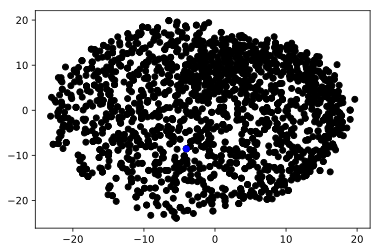

In [105]:
plt.scatter(pos[:,0], pos[:,1],c="black")
plt.scatter(pos[-1,0], pos[-1,1], c="blue")
del similarities

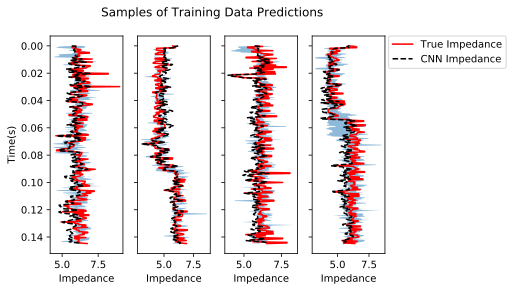

In [10]:
# Plotting various training results (impedance) with the input impedance

# Make one graph showing sample Training Data
sampleNumbers = np.array([2,54,123,209])

fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].invert_yaxis()
fig.suptitle('Samples of Training Data Predictions')

# Seismic traces
for i in range(4):
    sampleNumber = sampleNumbers[i];
    
    # Get an input seismic and impedance trace 
    TrainingSeismicTrace = Variable(trainX[sampleNumber:sampleNumber+1,:,:]).cuda()
    TrainingImpedanceTrace = Variable(trainIp[sampleNumber:sampleNumber+1,:,0]).cuda();
    # Calculate the impedance prediction
    CNN_ImpedancePrediction = cnn(TrainingSeismicTrace)
    
    # Calculate the posterior distribution from all data in ABC dataset
    posterior_data = TrainingImpedance_ABC

    l2_norm = np.zeros(posterior_data.shape[0])

    for ii in range(posterior_data.shape[0]):
        prediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
        l2_norm[ii] = np.linalg.norm((prediction - posterior_data[ii,:]), ord=2)
    
    N = 5; # Number of traces to pick for the posterior
    indx = l2_norm.argsort()[0:N]
    
    posteriorIp = posterior_data[indx]

    #Now Get the numpy versions
    TrainingSeismicTrace = trainX[sampleNumber,:].numpy().transpose()
    TrainingImpedanceTrace = trainIp[sampleNumber,:].numpy().transpose()
    CNN_ImpedancePrediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
    
    line1, = axs[i].plot(TrainingImpedanceTrace, time, 'r-')
    axs[i].set_xlabel('Impedance')
    if i==0:
        axs[i].set_ylabel('Time(s)')
    line2, = axs[i].plot(CNN_ImpedancePrediction, time, 'k--')
#     line3, = axs[i].plot(Ip_95percentile, time, 'k--')
#     line4, = axs[i].plot(Ip_5percentile, time, 'k--')
    axs[i].fill_betweenx(time, np.amin(posteriorIp, axis=0), np.amax(posteriorIp, axis=0), alpha=0.5)
    
lgd = plt.legend((line1, line2), ('True Impedance', 'CNN Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#fig.savefig('Figures/TrainigMatchesExamples.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', format='pdf', dpi=1200)

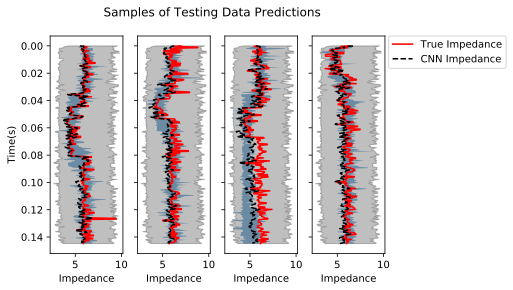

In [28]:
# Plotting various testing results (impedance) with the input impedance
sampleNumbers = np.array([21,109,160,180])
fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].invert_yaxis()
fig.suptitle('Samples of Testing Data Predictions')

for i in range(4):
    sampleNumber = sampleNumbers[i];   
    # Get an input seismic and impedance trace 
    TestingSetSeismicTrace = Variable(testX[sampleNumber:sampleNumber+1,:,:]).cuda()
    TestingSetImpedanceTrace = Variable(testIp[sampleNumber:sampleNumber+1,:,0]).cuda();
    # Calculate the impedance prediction
    CNN_ImpedancePrediction = cnn(TestingSetSeismicTrace)
    prediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
   # Calculate the posterior distribution from all data in ABC dataset
    posterior_data = TrainingImpedance_ABC
    l2_norm = np.zeros(posterior_data.shape[0])
    for ii in range(posterior_data.shape[0]):
        l2_norm[ii] = np.linalg.norm((prediction - posterior_data[ii,:]), ord=2)    
    N = 10; # Number of traces to pick for the posterior
    indx = l2_norm.argsort()[0:N]
    posteriorIp = posterior_data[indx]
    #Now Get the numpy versions
    TestingSetSeismicTrace = testX[sampleNumber,:].numpy().transpose()
    TestingSetImpedanceTrace = testIp[sampleNumber,:].numpy().transpose()
    CNN_ImpedancePrediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
    line1, = axs[i].plot(TestingSetImpedanceTrace, time, 'r-')
    axs[i].set_xlabel('Impedance')
    if i==0:
        axs[i].set_ylabel('Time(s)')
    line2, = axs[i].plot(CNN_ImpedancePrediction, time, 'k--')
    axs[i].fill_betweenx(time, np.amin(posteriorIp, axis=0), np.amax(posteriorIp, axis=0), alpha=0.5)
    axs[i].fill_betweenx(time, np.amin(posterior_data, axis=0), np.amax(posterior_data, axis=0), alpha=0.25, color='k')
    
lgd = plt.legend((line1, line2), ('True Impedance', 'CNN Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#fig.savefig('Figures/TestingExamples_withABC_plot_with_prior.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', format='pdf', dpi=1200)

[]

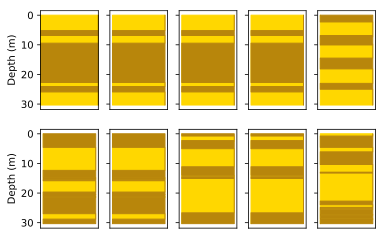

In [31]:
# Plot of the facies corresponding to the 10 traces of the last example
sampleNumber = 30;   
# Get an input seismic and impedance trace 
TestingSetSeismicTrace = Variable(testX[sampleNumber:sampleNumber+1,:,:]).cuda()
TestingSetImpedanceTrace = Variable(testIp[sampleNumber:sampleNumber+1,:,0]).cuda();
# Calculate the impedance prediction
CNN_ImpedancePrediction = cnn(TestingSetSeismicTrace)
prediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
# Calculate the posterior distribution from all data in ABC dataset
posterior_data = TrainingImpedance_ABC
l2_norm = np.zeros(posterior_data.shape[0])
for ii in range(posterior_data.shape[0]):
    l2_norm[ii] = np.linalg.norm((prediction - posterior_data[ii,:]), ord=2)    
N = 10; # Number of traces to pick for the posterior
indx = l2_norm.argsort()[0:N]

Facies_ABC_10 = Facies_ABC[indx]
diffDepth = 0.1524
Depth = np.arange(0, Facies_ABC_10.shape[-1])*diffDepth

# Plot of the 10 facies corresponding to indices indx
fig, axes = plt.subplots(2, 5, sharey=True)

# axes[0,0].plot(Facies_ABC_10[0], Depth, drawstyle="steps")
axes[0,0].invert_yaxis()
axes[0,0].set_ylabel('Depth (m)')
axes[0,0].fill_betweenx(Depth, Facies_ABC_10[0], step="pre", color="gold")
axes[0,0].fill_betweenx(Depth,Facies_ABC_10[0], 1, step="pre", color="darkgoldenrod")
axes[0,0].set_xticks([], [])
axes[0,0].autoscale(tight=True)
# axes[0,1].plot(Facies_ABC_10[1], Depth)
axes[0,1].fill_betweenx(Depth, Facies_ABC_10[1], step="pre", color="gold")
axes[0,1].fill_betweenx(Depth,Facies_ABC_10[1], 1, step="pre", color="darkgoldenrod")
axes[0,1].set_xticks([], [])
# axes[0,1].invert_yaxis()
# axes[0,2].plot(Facies_ABC_10[2], Depth)
axes[0,2].fill_betweenx(Depth, Facies_ABC_10[2], step="pre", color="gold")
axes[0,2].fill_betweenx(Depth,Facies_ABC_10[2], 1, step="pre", color="darkgoldenrod")
axes[0,2].set_xticks([], [])
# axes[0,2].invert_yaxis()
# axes[0,3].plot(Facies_ABC_10[3], Depth)
axes[0,3].fill_betweenx(Depth, Facies_ABC_10[3], step="pre", color="gold")
axes[0,3].fill_betweenx(Depth,Facies_ABC_10[3], 1, step="pre", color="darkgoldenrod")
axes[0,3].set_xticks([], [])
# axes[0,3].invert_yaxis()
# axes[0,4].plot(Facies_ABC_10[4], Depth)
axes[0,4].fill_betweenx(Depth, Facies_ABC_10[4], step="pre", color="gold")
axes[0,4].fill_betweenx(Depth,Facies_ABC_10[4], 1, step="pre", color="darkgoldenrod")
axes[0,4].set_xticks([], [])
# axes[0,4].invert_yaxis()
# axes[1,0].plot(Facies_ABC_10[5], Depth)
axes[1,0].fill_betweenx(Depth, Facies_ABC_10[5], step="pre", color="gold")
axes[1,0].fill_betweenx(Depth,Facies_ABC_10[5], 1, step="pre", color="darkgoldenrod")
axes[1,0].set_xticks([], [])
# axes[1,0].invert_yaxis()
axes[1,0].set_ylabel('Depth (m)')
# axes[1,1].plot(Facies_ABC_10[6], Depth)
axes[1,1].fill_betweenx(Depth, Facies_ABC_10[6], step="pre", color="gold")
axes[1,1].fill_betweenx(Depth,Facies_ABC_10[6], 1, step="pre", color="darkgoldenrod")
axes[1,1].set_xticks([], [])
# axes[1,1].invert_yaxis()
# axes[1,2].plot(Facies_ABC_10[7], Depth)
axes[1,2].fill_betweenx(Depth, Facies_ABC_10[7], step="pre", color="gold")
axes[1,2].fill_betweenx(Depth,Facies_ABC_10[7], 1, step="pre", color="darkgoldenrod")
axes[1,2].set_xticks([], [])
# axes[1,2].invert_yaxis()
# axes[1,3].plot(Facies_ABC_10[8], Depth)
axes[1,3].fill_betweenx(Depth, Facies_ABC_10[8], step="pre", color="gold")
axes[1,3].fill_betweenx(Depth,Facies_ABC_10[8], 1, step="pre", color="darkgoldenrod")
axes[1,3].set_xticks([], [])
# axes[1,3].invert_yaxis()
# axes[1,4].plot(Facies_ABC_10[9], Depth)
axes[1,4].fill_betweenx(Depth, Facies_ABC_10[9], step="pre", color="gold")
axes[1,4].fill_betweenx(Depth,Facies_ABC_10[9], 1, step="pre", color="darkgoldenrod")
axes[1,4].set_xticks([], [])
# axes[1,4].invert_yaxis()


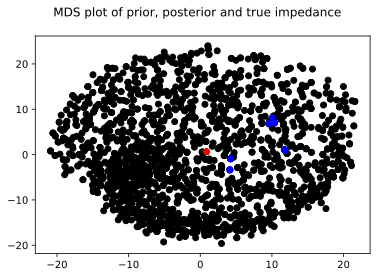

In [111]:
# Plotting in MDS space testing results (impedance) with the true impedance and prior ABC impedance
sampleNumbers = np.array([20])
fig, axs = plt.subplots(1, 1, sharey=True)

fig.suptitle('MDS plot of prior, posterior and true impedance')

for i in range(1):
    sampleNumber = sampleNumbers[i];   
    # Get an input seismic and impedance trace 
    TestingSetSeismicTrace = Variable(testX[sampleNumber:sampleNumber+1,:,:]).cuda()
    TestingSetImpedanceTrace = Variable(testIp[sampleNumber:sampleNumber+1,:,0]).cuda();
    # Calculate the impedance prediction
    CNN_ImpedancePrediction = cnn(TestingSetSeismicTrace)
    prediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
   # Calculate the posterior distribution from all data in ABC dataset
    posterior_data = TrainingImpedance_ABC
    l2_norm = np.zeros(posterior_data.shape[0])
    for ii in range(posterior_data.shape[0]):
        l2_norm[ii] = np.linalg.norm((prediction - posterior_data[ii,:]), ord=2)    
    N = 10; # Number of traces to pick for the posterior
    indx = l2_norm.argsort()[0:N]
    posteriorIp = posterior_data[indx]
    #Now Get the numpy versions
    TestingSetSeismicTrace = testX[sampleNumber,:].numpy().transpose()
    TestingSetImpedanceTrace = testIp[sampleNumber,:].numpy()
    CNN_ImpedancePrediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
    data_similarities = np.append(posterior_data, TestingSetImpedanceTrace, axis=0)
    
    similarities = euclidean_distances(data_similarities)
    
    seed = np.random.seed(9)
    mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)

    pos = mds.fit(similarities).embedding_
    plt.scatter(pos[:,0], pos[:,1], c="black")
    plt.scatter(pos[indx,0], pos[indx,1], c = "blue")
    plt.scatter(pos[-1,0], pos[-1,1], c="red")
    
          
#lgd = plt.legend((line1, line2), ('True Impedance', 'CNN Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#fig.savefig('Figures/TestingExamples_withABC.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', format='pdf', dpi=1200)

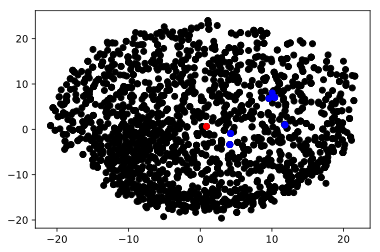

In [112]:
plt.scatter(pos[:,0], pos[:,1], c="black")
plt.scatter(pos[indx,0], pos[indx,1], c = "blue")
plt.scatter(pos[-1,0], pos[-1,1], c="red")
    
          
#lgd = plt.legend((line1, line2), ('True Impedance', 'CNN Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.savefig('Figures/TestingExamples_MDSplot_ABC.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', format='pdf', dpi=1200)

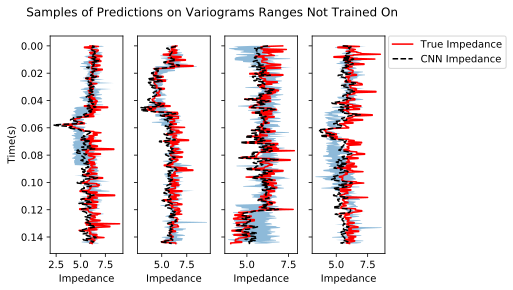

In [13]:
# Plotting various testing results (impedance) with the input impedance

# Make one graph showing sample Training Data
sampleNumbers = np.array([2,300,150,209])

fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].invert_yaxis()
fig.suptitle('Samples of Predictions on Variograms Ranges Not Trained On')

# Seismic traces
for i in range(4):
    sampleNumber = sampleNumbers[i];
    
    # Get an input seismic and impedance trace 
    TestingHardSeismicTrace = TestingSeismic[sampleNumber,:];
    TestingHardImpedanceTrace = TestingImpedance[sampleNumber, :];
    # Calculate the impedance prediction
    TestingHardSeismicTraceTorch = torch.FloatTensor(np.reshape(TestingHardSeismicTrace, (1,1,  TestingHardSeismicTrace.shape[0])))
    TestingHardSeismicTraceTorch = Variable(TestingHardSeismicTraceTorch).cuda()
    CNN_ImpedancePrediction = cnn(TestingHardSeismicTraceTorch)
    
    prediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
    
   # Calculate the posterior distribution from all data except ones used in training
    posterior_data = TrainingImpedance[:howManyToValidate+howManyToTest-1,fromWhich:tillWhich]

    l2_norm = np.zeros(posterior_data.shape[0])

    for ii in range(posterior_data.shape[0]):
        l2_norm[ii] = np.linalg.norm((prediction - posterior_data[ii:ii+1,:]), ord=2)
    
    N = 5; # Number of traces to pick for the posterior
    indx = l2_norm.argsort()[0:N]
    
    posteriorIp = posterior_data[indx]

    #Now Get the numpy versions
    CNN_ImpedancePrediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
    
    line1, = axs[i].plot(TestingHardImpedanceTrace, time, 'r-')
    axs[i].set_xlabel('Impedance')
    if i==0:
        axs[i].set_ylabel('Time(s)')
    line2, = axs[i].plot(CNN_ImpedancePrediction, time, 'k--')
    axs[i].fill_betweenx(time, np.amin(posteriorIp, axis=0), np.amax(posteriorIp, axis=0), alpha=0.5)

lgd = plt.legend((line1, line2), ('True Impedance', 'CNN Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.savefig('Figures/Challenge_test.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', format='pdf', dpi=1200)

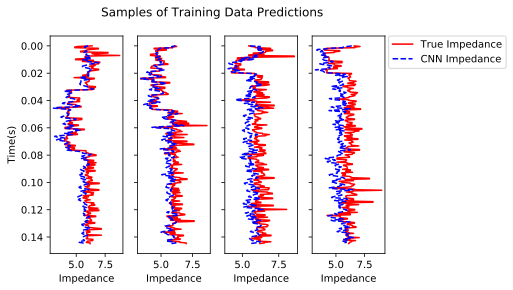

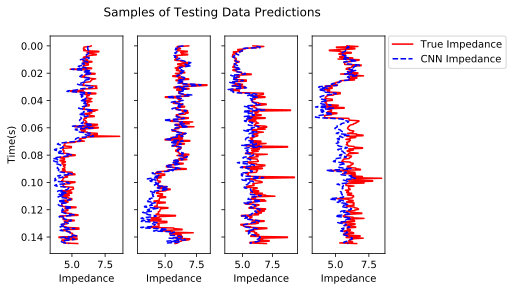

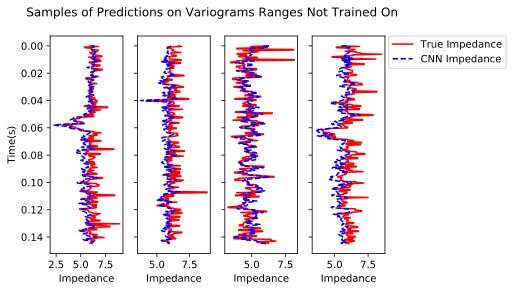

In [26]:
# Plotting various training results (impedance) with the input impedance

# Make one graph showing sample Training Data
sampleNumbers = np.array([2,54,123,209])

fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].invert_yaxis()
fig.suptitle('Samples of Training Data Predictions')

# Seismic traces
for i in range(4):
    sampleNumber = sampleNumbers[i];
    
    # Get an input seismic and impedance trace 
    TrainingSeismicTrace = Variable(trainX[sampleNumber:sampleNumber+1,:,:]).cuda()
    TrainingImpedanceTrace = Variable(trainIp[sampleNumber:sampleNumber+1,:,0]).cuda();
    # Calculate the impedance prediction
    CNN_ImpedancePrediction = cnn(TrainingSeismicTrace)

    #Now Get the numpy versions
    TrainingSeismicTrace = trainX[sampleNumber,:].numpy().transpose()
    TrainingImpedanceTrace = trainIp[sampleNumber,:].numpy().transpose()
    CNN_ImpedancePrediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
    
    line1, = axs[i].plot(TrainingImpedanceTrace, time, 'r-')
    axs[i].set_xlabel('Impedance')
    if i==0:
        axs[i].set_ylabel('Time(s)')
    line2, = axs[i].plot(CNN_ImpedancePrediction, time, 'b--')
lgd = plt.legend((line1, line2), ('True Impedance', 'CNN Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# fig.savefig('Figures/TrainigMatchesExamples.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Plotting various testing results (impedance) with the input impedance

# Make one graph showing sample Training Data
sampleNumbers = np.array([2,54,123,209])

fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].invert_yaxis()
fig.suptitle('Samples of Testing Data Predictions')

# Seismic traces
for i in range(4):
    sampleNumber = sampleNumbers[i];
    
    # Get an input seismic and impedance trace 
    TestingSetSeismicTrace = Variable(testX[sampleNumber:sampleNumber+1,:,:]).cuda()
    TestingSetImpedanceTrace = Variable(testIp[sampleNumber:sampleNumber+1,:,0]).cuda();
    # Calculate the impedance prediction
    CNN_ImpedancePrediction = cnn(TestingSetSeismicTrace)

    #Now Get the numpy versions
    TestingSetSeismicTrace = testX[sampleNumber,:].numpy().transpose()
    TestingSetImpedanceTrace = testIp[sampleNumber,:].numpy().transpose()
    CNN_ImpedancePrediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
    
    line1, = axs[i].plot(TestingSetImpedanceTrace, time, 'r-')
    axs[i].set_xlabel('Impedance')
    if i==0:
        axs[i].set_ylabel('Time(s)')
    line2, = axs[i].plot(CNN_ImpedancePrediction, time, 'b--')
lgd = plt.legend((line1, line2), ('True Impedance', 'CNN Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# fig.savefig('Figures/TestingMatchesExamples.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Plotting various testing results (impedance) with the input impedance

# Make one graph showing sample Training Data
sampleNumbers = np.array([2,334,123,209])

fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].invert_yaxis()
fig.suptitle('Samples of Predictions on Variograms Ranges Not Trained On')

# Seismic traces
for i in range(4):
    sampleNumber = sampleNumbers[i];
    
    # Get an input seismic and impedance trace 
    TestingHardSeismicTrace = TestingSeismic[sampleNumber,:];
    TestingHardImpedanceTrace = TestingImpedance[sampleNumber, :];
    # Calculate the impedance prediction
    TestingHardSeismicTraceTorch = torch.FloatTensor(np.reshape(TestingHardSeismicTrace, (1,1,  TestingHardSeismicTrace.shape[0])))
    TestingHardSeismicTraceTorch = Variable(TestingHardSeismicTraceTorch).cuda()
    CNN_ImpedancePrediction = cnn(TestingHardSeismicTraceTorch)

    #Now Get the numpy versions
    CNN_ImpedancePrediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
    
    line1, = axs[i].plot(TestingHardImpedanceTrace, time, 'r-')
    axs[i].set_xlabel('Impedance')
    if i==0:
        axs[i].set_ylabel('Time(s)')
    line2, = axs[i].plot(CNN_ImpedancePrediction, time, 'b--')
lgd = plt.legend((line1, line2), ('True Impedance', 'CNN Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# fig.savefig('Figures/TestingHardMatchesExamples.png', bbox_extra_artists=(lgd,), bbox_inches='tight')



In [13]:
# Get the whole success rates using different metrics

testX = (TrainingSeismic[howManyToValidate:howManyToValidate+howManyToTest,fromWhich:tillWhich])
trainX = (TrainingSeismic[howManyToValidate+howManyToTest:,fromWhich:tillWhich])
testIp = (TrainingImpedance[howManyToValidate:howManyToValidate+howManyToTest,0:-fromWhich+tillWhich])
trainIp = (TrainingImpedance[howManyToValidate+howManyToTest:,0:-fromWhich+tillWhich])

n_train=trainIp.shape[0]
n_testhard=TestingSeismic.shape[0]
n_test=testX.shape[0]

#1
NormXCorrErrTraining = np.zeros((n_train))
NormXCorrErrTesting = np.zeros((n_test))
NormXCorrErrTestingHard = np.zeros((n_testhard))

#2
AverageAbsoluteErrorTraining = np.zeros((n_train))
AverageAbsoluteErrorTesting = np.zeros((n_test))
AverageAbsoluteErrorTestingHard = np.zeros((n_testhard))

#3
AverageRMSETraining =  np.zeros((n_train))
AverageRMSETesting =  np.zeros((n_test))
AverageRMSETestingHard =  np.zeros((n_testhard))

#4
AbsoluteErrorPercentageTraining =  np.zeros((n_train))
AbsoluteErrorPercentageTesting =  np.zeros((n_test))
AbsoluteErrorPercentageTestingHard =  np.zeros((n_testhard))

#5
L1normByMeanIpTrain = np.zeros((n_train))
L1normByMeanIpTest = np.zeros((n_test))
L1normByMeanIpTestingHard = np.zeros((n_testhard))

rangeAllImpedanceTraining = trainIp.max() - trainIp.min();
rangeAllImpedanceTesting = testIp.max() - testIp.min();
rangeAllImpedanceTestingHard = TestingImpedance.max() - TestingImpedance.min();

print('Range of all impedance is: ' + str(rangeAllImpedanceTesting))


#Get values for testing data
for i in range(n_train):
    sampleNumber = i
    if i%100==0:
        print(sampleNumber)
    
    #Get Data
    SeismicTrace = trainX[sampleNumber,:]
    IpTrace = trainIp[sampleNumber,:]

    SeismicTrace = torch.FloatTensor(np.reshape(SeismicTrace, (1,1, SeismicTrace.shape[0])))
    traces = Variable(SeismicTrace).cuda()
    outputs = cnn(traces)

    CNN_Impedance_Trace = outputs.data.cpu().numpy()[0,0,:]
    CNN_Impedance_Trace_norm = (CNN_Impedance_Trace - np.mean(CNN_Impedance_Trace)) / (np.std(CNN_Impedance_Trace) * len(CNN_Impedance_Trace))
    datasetIp_norm = (IpTrace - np.mean(IpTrace)) /  np.std(IpTrace)
    NormXCorrErrTraining[i] = (np.correlate(CNN_Impedance_Trace_norm, datasetIp_norm))
    
    AverageAbsoluteErrorTraining[i] = (np.absolute(IpTrace - CNN_Impedance_Trace)).mean()
    AverageRMSETraining[i] = np.sqrt(np.mean((IpTrace-CNN_Impedance_Trace)**2));
    AbsoluteErrorPercentageTraining[i] = 1-AverageAbsoluteErrorTraining[i]/rangeAllImpedanceTraining
    
    L1normByMeanIpTrain[i] = ((np.absolute(IpTrace - CNN_Impedance_Trace)).mean())/IpTrace.mean()

    
#Get values for testing data
for i in range(n_test):
    sampleNumber = i
    if i%100==0:
        print(sampleNumber)
    
    #Get Data
    SeismicTrace = testX[sampleNumber,:]
    IpTrace = testIp[sampleNumber,:]

    SeismicTrace = torch.FloatTensor(np.reshape(SeismicTrace, (1,1, SeismicTrace.shape[0])))
    traces = Variable(SeismicTrace).cuda()
    outputs = cnn(traces)

    CNN_Impedance_Trace = outputs.data.cpu().numpy()[0,0,:]
    CNN_Impedance_Trace_norm = (CNN_Impedance_Trace - np.mean(CNN_Impedance_Trace)) / (np.std(CNN_Impedance_Trace) * len(CNN_Impedance_Trace))
    datasetIp_norm = (IpTrace - np.mean(IpTrace)) /  np.std(IpTrace)
    NormXCorrErrTesting[i] = (np.correlate(CNN_Impedance_Trace_norm, datasetIp_norm))
    
    AverageAbsoluteErrorTesting[i] = (np.absolute(IpTrace - CNN_Impedance_Trace)).mean()
    AverageRMSETesting[i] = np.sqrt(np.mean((IpTrace-CNN_Impedance_Trace)**2));
    AbsoluteErrorPercentageTesting[i] = 1-AverageAbsoluteErrorTesting[i]/rangeAllImpedanceTesting
    
    L1normByMeanIpTest[i] = ((np.absolute(IpTrace - CNN_Impedance_Trace)).mean())/IpTrace.mean()
    
#Get values for testing hard data
for i in range(n_testhard):
    sampleNumber = i
    if i%100==0:
        print(sampleNumber)
    
    #Get Data
    SeismicTrace = TestingSeismic[sampleNumber,:]
    IpTrace = TestingImpedance[sampleNumber,:]

    SeismicTrace = torch.FloatTensor(np.reshape(SeismicTrace, (1,1, SeismicTrace.shape[0])))
    traces = Variable(SeismicTrace).cuda()
    outputs = cnn(traces)

    CNN_Impedance_Trace = outputs.data.cpu().numpy()[0,0,:]
    CNN_Impedance_Trace_norm = (CNN_Impedance_Trace - np.mean(CNN_Impedance_Trace)) / (np.std(CNN_Impedance_Trace) * len(CNN_Impedance_Trace))
    datasetIp_norm = (IpTrace - np.mean(IpTrace)) /  np.std(IpTrace)
    NormXCorrErrTestingHard[i] = (np.correlate(CNN_Impedance_Trace_norm, datasetIp_norm))
    
    AverageAbsoluteErrorTestingHard[i] = (np.absolute(IpTrace - CNN_Impedance_Trace)).mean()
    AverageRMSETestingHard[i] = np.sqrt(np.mean((IpTrace-CNN_Impedance_Trace)**2));
    AbsoluteErrorPercentageTestingHard[i] = 1-AverageAbsoluteErrorTesting[i]/rangeAllImpedanceTestingHard
    
    L1normByMeanIpTestingHard[i] = ((np.absolute(IpTrace - CNN_Impedance_Trace)).mean())/IpTrace.mean()
    

Range of all impedance is: 7.23024986061
0
100
200
300
400
500
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600


In [27]:
np.savetxt('VariogramTrain.dat',AverageAbsoluteErrorTraining , delimiter=',')
np.savetxt('VariogramTest.dat',AverageAbsoluteErrorTesting , delimiter=',')
np.savetxt('VariogramHard.dat',AverageAbsoluteErrorTestingHard , delimiter=',')


In [32]:
L1normByMeanIpTest

array([ 0.0535143 ,  0.04834861,  0.05200633,  0.04747955,  0.04977008,
        0.04339205,  0.05806451,  0.07037959,  0.05420061,  0.05141586,
        0.04086026,  0.04302868,  0.05204474,  0.0540482 ,  0.05254472,
        0.03982435,  0.04521935,  0.04744294,  0.0531747 ,  0.04265436,
        0.04215793,  0.04478136,  0.04639705,  0.04345171,  0.04698642,
        0.04870729,  0.05467723,  0.04386948,  0.04103036,  0.05747769,
        0.04635008,  0.04764645,  0.04409655,  0.0436715 ,  0.03924149,
        0.04818381,  0.0528601 ,  0.05605209,  0.04228632,  0.05590936,
        0.05629962,  0.06336617,  0.05306537,  0.06614698,  0.04289803,
        0.04048817,  0.04702624,  0.05218896,  0.04603056,  0.05692319,
        0.04195451,  0.03854365,  0.05670589,  0.10672595,  0.0377251 ,
        0.05982176,  0.05203568,  0.05439804,  0.07222916,  0.04267596,
        0.05085053,  0.0636768 ,  0.04945325,  0.04116927,  0.05708049,
        0.05567325,  0.04702624,  0.04950862,  0.04444307,  0.04

In [14]:
np.savetxt('PercentVariogramTrain.dat',L1normByMeanIpTrain , delimiter=',')
np.savetxt('PercentVariogramTest.dat',L1normByMeanIpTest , delimiter=',')
np.savetxt('PercentVariogramHard.dat',L1normByMeanIpTestingHard , delimiter=',')

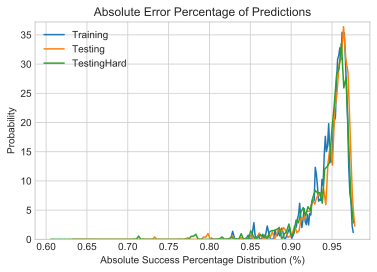

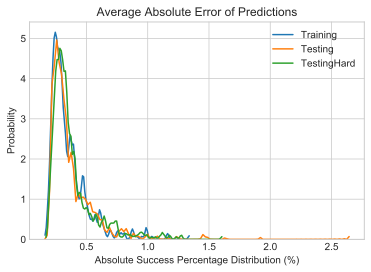

In [13]:
nbinshistogram = 60
smoothingFactor = 100; # higher is smoother


fig = plt.figure()
sns.set_style('whitegrid')
plt.xlabel('Absolute Success Percentage Distribution (%)')
plt.ylabel('Probability')
plt.title('Absolute Error Percentage of Predictions')

Line_AbsErrPercentTraining = sns.kdeplot(np.array(AbsoluteErrorPercentageTraining), bw=0.001, cut=0, label='Training')
ErrorPercentageTrainData = Line_AbsErrPercentTraining.get_lines()[0].get_data()
np.savetxt('averageErrorTrainPercent.dat', ErrorPercentageTrainData, delimiter=',')

Line_AbsErrPercentTesting = sns.kdeplot(np.array(AbsoluteErrorPercentageTesting), bw=0.001, cut=0, label='Testing')
ErrorPercentageTestData = Line_AbsErrPercentTesting.get_lines()[0].get_data()
np.savetxt('averageErrorTestPercent.dat', ErrorPercentageTestData, delimiter=',')

Line_AbsErrPercentTestingHard = sns.kdeplot(np.array(AbsoluteErrorPercentageTestingHard), bw=0.001, cut=0, label='TestingHard')
ErrorPercentageTestDataHard = Line_AbsErrPercentTestingHard.get_lines()[0].get_data()
np.savetxt('averageErrorTestPercentHard.dat', ErrorPercentageTestDataHard, delimiter=',')

lgd = plt.legend() 

fig.savefig('Figures/AverageErrorPercentagePrediction.png') 

fig = plt.figure()
sns.set_style('whitegrid')
plt.xlabel('Absolute Success Percentage Distribution (%)')
plt.ylabel('Probability')
plt.title('Average Absolute Error of Predictions')

Line_AbsErrPercentTraining = sns.kdeplot(np.array(AverageAbsoluteErrorTraining), bw=0.01, cut=0, label='Training')
ErrorPercentageTrainData = Line_AbsErrPercentTraining.get_lines()[0].get_data()
np.savetxt('averageErrorTrainAbs.dat', ErrorPercentageTrainData, delimiter=',')

Line_AbsErrPercentTesting = sns.kdeplot(np.array(AverageAbsoluteErrorTesting), bw=0.01, cut=0, label='Testing')
ErrorPercentageTestData = Line_AbsErrPercentTesting.get_lines()[0].get_data()
np.savetxt('averageErrorTestAbs.dat', ErrorPercentageTestData, delimiter=',')

Line_AbsErrPercentTestingHard = sns.kdeplot(np.array(AverageAbsoluteErrorTestingHard), bw=0.01, cut=0, label='TestingHard')
ErrorPercentageTestDataHard = Line_AbsErrPercentTestingHard.get_lines()[0].get_data()
np.savetxt('averageErrorTestAbsHard.dat', ErrorPercentageTestDataHard, delimiter=',')

lgd = plt.legend() 

fig.savefig('Figures/AverageErrorPrediction.png') 

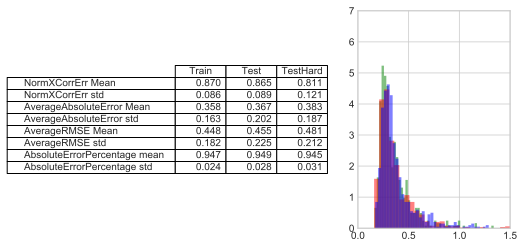

In [14]:
fig = plt.figure()
fig, axs =plt.subplots(1,2)

n, bins, patches = axs[1].hist(AverageAbsoluteErrorTraining, 50, density=True, facecolor='g', alpha=0.5)
n, bins, patches = axs[1].hist(AverageAbsoluteErrorTesting, 50, density=True, facecolor='r', alpha=0.5)
n, bins, patches = axs[1].hist(AverageAbsoluteErrorTestingHard, 50, density=True, facecolor='b', alpha=0.5)
plt.axis([0, 1.5, 0, 7])

data = [[NormXCorrErrTraining.mean(),NormXCorrErrTesting.mean(),NormXCorrErrTestingHard.mean()] ,
        [NormXCorrErrTraining.std(),NormXCorrErrTesting.std(),NormXCorrErrTestingHard.std()],
        [AverageAbsoluteErrorTraining.mean(),AverageAbsoluteErrorTesting.mean(),AverageAbsoluteErrorTestingHard.mean()],
        [AverageAbsoluteErrorTraining.std(),AverageAbsoluteErrorTesting.std(),AverageAbsoluteErrorTestingHard.std()],
        [AverageRMSETraining.mean(),AverageRMSETesting.mean(),AverageRMSETestingHard.mean()], 
        [AverageRMSETraining.std(),AverageRMSETesting.std(),AverageRMSETestingHard.std()], 
        [AbsoluteErrorPercentageTraining.mean(),AbsoluteErrorPercentageTesting.mean(),AbsoluteErrorPercentageTestingHard.mean()],
        [AbsoluteErrorPercentageTraining.std(),AbsoluteErrorPercentageTesting.std(),AbsoluteErrorPercentageTestingHard.std()]]


# NormXCorrErrTraining[i] = (np.correlate(CNN_Impedance_Trace_norm, datasetIp_norm))
    
#     AverageAbsoluteErrorTraining[i] = (np.absolute(IpTrace - CNN_Impedance_Trace)).mean()
#     AverageRMSETraining[i] = np.sqrt(np.mean((IpTrace-CNN_Impedance_Trace)**2));
#     AbsoluteErrorPercentageTraining[i] = 1-AverageAbsoluteErrorTraining[i]/rangeAllImpedanceTraining


columns = ('Train', 'Test', 'TestHard')
rows = ['NormXCorrErr Mean', 'NormXCorrErr std',
        'AverageAbsoluteError Mean', 'AverageAbsoluteError std',
        'AverageRMSE Mean','AverageRMSE std', 
        'AbsoluteErrorPercentage mean', 'AbsoluteErrorPercentage std']
n_rows = len(rows)
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    cell_text.append(['%1.3f' % (x) for x in data[row]])

axs[0].axis('tight')
axs[0].axis('off')
# Add a table at the bottom of the axes
the_table = axs[0].table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')

# Adjust layout to make room for the table:
fig.savefig('Figures/TableErrors.png') 

In [ ]:
#The BIG Trash can

#plot some seismic line
whichSample = 280
numberSamples = testX.shape[2]
traces = testX[whichSample:whichSample+1,:,50:].numpy()

xvals = np.linspace(0, traces.shape[2], numberSamples)
x1 = np.linspace(0, traces.shape[2], traces.shape[2])

yinterp = np.interp(xvals, x1, traces[0,0,:])

plt.plot(xvals, yinterp)
plt.plot(x1,traces[0,0,:],'-r')

testIp.shape

#plot predicted + true impedance and seismic on same line
traces = Variable(torch.FloatTensor(np.reshape(yinterp, (1, 1, yinterp.shape[0])))).cuda()
# traces = Variable(torch.FloatTensor(yinterp)).cuda()

yy = Variable(testIp[whichSample:whichSample+1,:,0]).cuda();
outputs = cnn(traces)
#print(truRC.shape)
#truRC = testY[whichSample,:].numpy()

truIp = testIp[whichSample,0,50:].numpy()
truIp = np.interp(xvals, x1, truIp)
input1 = testX[whichSample,0,50:].numpy()
line1, = plt.plot(outputs.data.cpu().numpy()[0,0,:],'r')
line2, = plt.plot(truIp,'--k')
plt.title("Test data")
plt.xlabel("Index")
plt.ylabel("Impedance")
plt.legend((line1, line2), ('CNN Impedance', 'True Impedance'))

plt.plot(yinterp*3)

#######################################################################################
# Plotting the test result

whichSample = 50
fig = plt.figure()
traces = Variable(testX[whichSample:whichSample+1,:,:]).cuda()
yy = Variable(testIp[whichSample:whichSample+1,:,0]).cuda();
outputs = cnn(traces)
# truRC = testY[whichSample,:].numpy()
truIp = testIp[whichSample,:].numpy()
input1 = testX[whichSample,:].numpy()
line1, = plt.plot(outputs.data.cpu().numpy()[0,0,:],'r')
line2, = plt.plot(truIp[0,:],'--k')
plt.title("Test data")
plt.xlabel("Index")
plt.ylabel("Impedance")
plt.legend((line1, line2), ('CNN Impedance', 'True Impedance'))
fig.savefig('Figures/TestingDataImpedancePrediction.png') 
##########################################################################################
datasetXRicker = torch.FloatTensor(np.reshape(datasetXRicker, (1,1, datasetXRicker.shape[0])))

plt.plot(testX[1,0,:].numpy())
plt.plot(datasetXRicker[0,0,:].numpy())
#######################################################################################
mu = np.mean(NormXCorrErr)
sigma = np.std(NormXCorrErr)

# the histogram of the data
n, bins, patches = plt.hist(NormXCorrErr, 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Normalized Cross Correlation Coeffcient')
plt.ylabel('Probability')
plt.title('Histogram of Normalized X-Cor Coefficient Accuracy Metric (Test Hard)')
plt.text(0.20, 2, r'$\mu='+str(mu)+',\ \sigma=' + str(sigma) +'$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

####################
nbins = 100
fig = plt.figure()
plt.xlabel('Normalized Cross Correlation Coeffcient and AbsoluteErrorPercentag')
plt.ylabel('Probability')
plt.title('Normalized Error Plots')
p, x = np.histogram(NormXCorrErr, bins=nbins) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=nbins)
line1, = plt.plot(x, f(x))

p, x = np.histogram(AbsoluteErrorPercentage, bins=nbins) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=nbins)
line2, = plt.plot(x, f(x))
lgd = plt.legend((line1, line2), ('NormXCorrErr', 'AbsoluteErrorPercentage'))

fig.savefig('Figures/TestingDataImpedancePrediction.png') 

fig = plt.figure()
plt.xlabel('Average RMSE and Average Absolute Error')
plt.ylabel('Probability')
plt.title('Average Error Plots')
p, x = np.histogram(AverageRMSE, bins=nbins) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=nbins)
line1, = plt.plot(x, f(x))

p, x = np.histogram(AverageAbsoluteError, bins=nbins) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=nbins)
line2, = plt.plot(x, f(x))
lgd = plt.legend((line1, line2), ('AverageRMSE', 'AverageAbsoluteError'))
fig.savefig('Figures/TestingDataImpedancePrediction.png') 


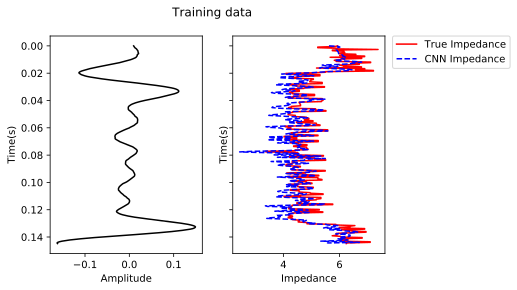

In [16]:
# Plotting training results (impedance) with the input impedance with seismic data

# Make one graph showing sample Training Data
sampleNumbers = np.array([21])

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].invert_yaxis()
fig.suptitle('Training data')

# Seismic traces
for i in range(1):
    sampleNumber = sampleNumbers[i];
    
    # Get an input seismic and impedance trace 
    TrainingSeismicTrace = Variable(trainX[sampleNumber:sampleNumber+1,:,:]).cuda()
    TrainingImpedanceTrace = Variable(trainIp[sampleNumber:sampleNumber+1,:,0]).cuda();
    # Calculate the impedance prediction
    CNN_ImpedancePrediction = cnn(TrainingSeismicTrace)

    #Now Get the numpy versions
    TrainingSeismicTrace = trainX[sampleNumber,:].numpy().transpose()
    TrainingImpedanceTrace = trainIp[sampleNumber,:].numpy().transpose()
    CNN_ImpedancePrediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
    
    line1, = axs[i+1].plot(TrainingImpedanceTrace, time, 'r-')
    axs[i+1].set_xlabel('Impedance')
    axs[i+1].set_ylabel('Time(s)')
    line2, = axs[i+1].plot(CNN_ImpedancePrediction, time, 'b--')

lgd = plt.legend((line1, line2), ('True Impedance', 'CNN Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

line3, = axs[0].plot(TrainingSeismicTrace, time, 'k-')
axs[0].set_xlabel('Amplitude')
axs[0].set_ylabel('Time(s)')

fig.savefig('Figures/Trainig_Seismic_Impedance.eps', bbox_extra_artists=(lgd,), bbox_inches='tight', format='eps', dpi=1000)   

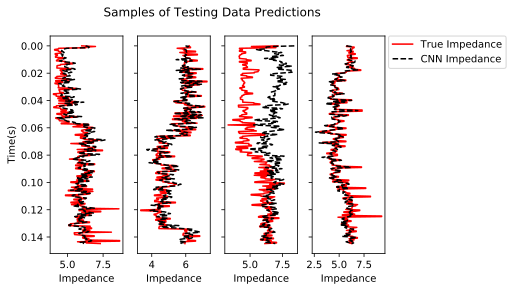

In [43]:
# Output some test data for comparison with sparse deconvolution and Jason's inversion
# Testing output of neural network prior to export (Data selected from testing dataset not used in the training process)

sampleNumbers = np.array([15,54,123,209])
fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].invert_yaxis()
fig.suptitle('Samples of Testing Data Predictions')

for i in range(4):
    sampleNumber = sampleNumbers[i];
    
    # Get an input seismic and impedance trace 
    TestingSetSeismicTrace = Variable(testX[sampleNumber:sampleNumber+1,:,:]).cuda()
    TestingSetImpedanceTrace = Variable(testIp[sampleNumber:sampleNumber+1,:,0]).cuda();
    # Calculate the impedance prediction
    CNN_ImpedancePrediction = cnn(TestingSetSeismicTrace)
    
    prediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
    
#    # Calculate the posterior distribution from all data except ones used in training
#     posterior_data = TrainingImpedance[:howManyToValidate+howManyToTest-1,fromWhich:tillWhich]
#     l1_norm = np.zeros(posterior_data.shape[0])

#     for ii in range(posterior_data.shape[0]):
#         l1_norm[ii] = np.linalg.norm((prediction - posterior_data[ii:ii+1,:]), ord=1)
    
#     N = 5; # Number of traces to pick for the posterior
#     indx = l1_norm.argsort()[0:N]
    
#     posteriorIp = posterior_data[indx]
    
    #Now Get the numpy versions
    TestingSetSeismicTrace = testX[sampleNumber,:].numpy().transpose()
    TestingSetImpedanceTrace = testIp[sampleNumber,:].numpy().transpose()
    CNN_ImpedancePrediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
    
    # Output seismic impedance and corresponding seismic impedance vs time 
    np.savetxt("../../Comparison_other_methods/trace_number_{}.txt".format(sampleNumber), np.transpose([time,TestingSetSeismicTrace[:,0],TestingSetImpedanceTrace[:,0]]), delimiter=',', header='Time, Seismogram, Impedance') 

    
    line1, = axs[i].plot(TestingSetImpedanceTrace, time, 'r-')
    axs[i].set_xlabel('Impedance')
    if i==0:
        axs[i].set_ylabel('Time(s)')
    line2, = axs[i].plot(CNN_ImpedancePrediction, time, 'k--')
#     axs[i].fill_betweenx(time, np.amin(posteriorIp, axis=0), np.amax(posteriorIp, axis=0), alpha=0.5)
    
lgd = plt.legend((line1, line2), ('True Impedance', 'CNN Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# fig.savefig('Figures/TestingExamples_ABC.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', format='pdf', dpi=1200)




In [41]:
test = (time,TestingSetSeismicTrace[:,0],TestingSetImpedanceTrace[:,0])


(array([ 0.        ,  0.00043875,  0.0008775 ,  0.00131625,  0.001755  ,
         0.00219375,  0.0026325 ,  0.00307125,  0.00351   ,  0.00394875,
         0.0043875 ,  0.00482625,  0.005265  ,  0.00570375,  0.0061425 ,
         0.00658125,  0.00702   ,  0.00745875,  0.0078975 ,  0.00833625,
         0.008775  ,  0.00921375,  0.0096525 ,  0.01009125,  0.01053   ,
         0.01096875,  0.0114075 ,  0.01184625,  0.012285  ,  0.01272375,
         0.0131625 ,  0.01360125,  0.01404   ,  0.01447875,  0.0149175 ,
         0.01535625,  0.015795  ,  0.01623375,  0.0166725 ,  0.01711125,
         0.01755   ,  0.01798875,  0.0184275 ,  0.01886625,  0.019305  ,
         0.01974375,  0.0201825 ,  0.02062125,  0.02106   ,  0.02149875,
         0.0219375 ,  0.02237625,  0.022815  ,  0.02325375,  0.0236925 ,
         0.02413125,  0.02457   ,  0.02500875,  0.0254475 ,  0.02588625,
         0.026325  ,  0.02676375,  0.0272025 ,  0.02764125,  0.02808   ,
         0.02851875,  0.0289575 ,  0.02939625,  0.0